## Import thư viện cần thiết

In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import random
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
!pip install ultralytics
from ultralytics import YOLO

## Extract data from xml file
Với tập dataset hiện có, trước tiên ta cần trích xuất các từ trong mỗi ảnh, mỗi một từ được khoanh vùng bởi bounding box và label cho mỗi từ đó, sau khi trích xuất sẽ đẩy những thông tin này cho các bước tiếp theo để tiến hành cắt ảnh theo bounding box và chia thành các tập train, val, test


In [ ]:
def extract_data_from_xml_file(root_dir):
    xml_path = os.path.join(root_dir, 'words.xml')
    #trong dataset tồn tại 3 file xml là words, segmentations (kí tự), locations(toàn bộ đoạn văn)
    #nhưng với bài toán này ta cần thực hiện tách theo từ (words)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []
    for img in root:
        label_in_img = []
        bb_in_img = []
        for bbs in img.findall('taggedRectangles'):
            for bb in bbs:
                if not bb[0].text.isalnum(): #kiểm tra xem từ đó có phải chữ hay số không
                    continue
                if ' ' in bb[0].text.lower(): #kiểm tra khoảng trắng trong từ đó
                    continue
                bb_in_img.append([
                    float(bb.attrib['x']),
                    float(bb.attrib['y']),
                    float(bb.attrib['width']),
                    float(bb.attrib['height'])
                ])
                label_in_img.append(bb[0].text.lower())
        img_path = os.path.join(root_dir, img[0].text)
        img_paths.append(img_path)
        img_sizes.append([int(img[1].attrib['x']), int(img[1].attrib['y'])])
        img_labels.append(label_in_img)
        bboxes.append(bb_in_img)
    return img_paths, img_sizes, img_labels, bboxes
root_dir = '/kaggle/input/icdar2003/icdar2003/SceneTrialTrain'
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml_file(root_dir)

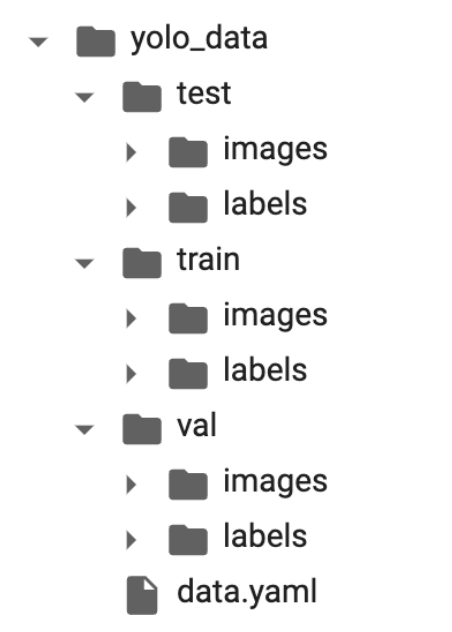

 Ta sẽ có 3 folder chính là
train, test, và val, trong mỗi folder ta có 2 folder là images và labels. Folder images sẽ
chỉ chứa các hình ảnh, ứng với từng file trong folder images sẽ có 1 file tương ứng cùng
tên (khác đuôi file, ví dụ *.png và *.txt) trong folder labels, trong file label sẽ sẽ chứa
thông tin label và tọa độ của từng bounding box.

In [ ]:
def convert_to_yolov8_format(image_paths, image_sizes, bboxes):
    yolov8_data = []
    for image_path, image_size, bbs in zip(image_paths, image_sizes, bboxes):
        img_width, img_height = image_size
        yolov8_labels = []
        for bb in bbs:
            x, y, width, height = bb
            x_center = (x + width / 2) / img_width
            y_center = (y + height / 2) / img_height
            normalized_width = width / img_width
            normalized_height = height / img_height
            class_id = 0
            yolov8_label = f"{class_id} {x_center} {y_center} {normalized_width} {normalized_height}"
            yolov8_labels.append(yolov8_label)
        yolov8_data.append((image_path, yolov8_labels))
    return yolov8_data
yolov8_data = convert_to_yolov8_format(img_paths, img_sizes, bboxes)


In [ ]:
for img_path, yolov8_labels in yolov8_data:
    print(img_path, yolov8_labels)
    break

## Lưu lại các file theo cấu trúc dùng cho các bước tiếp theo


In [ ]:
def save_data(data, src_img_dir, save_dir):
    os.makedirs(save_dir, exist_ok = True)
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok = True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok = True)

    for img_path, yolov8_labels in data:
        shutil.copy(
            os.path.join(src_img_dir, img_path),
            os.path.join(save_dir, 'images')
        )
        img_name = os.path.basename(img_path)
        img_name = os.path.splitext(img_name)[0]
        with open(os.path.join(save_dir, 'labels', f"{img_name}.txt"), 'w') as f:
            for label in yolov8_labels:
                f.write(f"{label}\n")
random_state = 42
val_size = 0.2
test_size = 0.1
is_shuffle = True
train_data, test_data = train_test_split(yolov8_data, test_size = val_size, shuffle = is_shuffle)
test_data, val_data = train_test_split(test_data, test_size = test_size, shuffle = is_shuffle)
yolo_data_dir = 'yolo_data'

os.makedirs(yolo_data_dir, exist_ok = True)

save_train_dir = os.path.join(yolo_data_dir, 'train')
save_test_dir = os.path.join(yolo_data_dir, 'test')
save_val_dir = os.path.join(yolo_data_dir, 'val')

save_data(train_data, root_dir, save_train_dir)
save_data(test_data, root_dir, save_test_dir)
save_data(val_data, root_dir, save_val_dir)

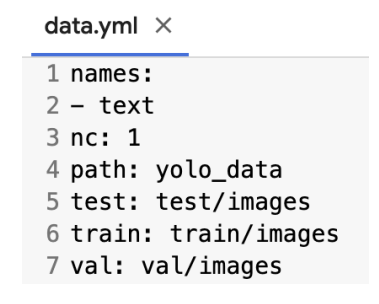

## File yaml cần được lưu trữ trên cấu trúc cụ thể

In [ ]:
import yaml
class_labels = ['text']
data_yaml = {
    'names':class_labels,
    'nc': 1,
    'path': '/kaggle/working/yolo_data',
    'test': '/kaggle/working/yolo_data/test/images',
    'train': '/kaggle/working/yolo_data/train/images',
    'val': '/kaggle/working/yolo_data/val/images'
}
yolo_yaml_path = os.path.join(yolo_data_dir, 'data.yaml')
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

In [ ]:
print(os.path.abspath(yolo_yaml_path))

## Train model yolo

In [ ]:
from ultralytics import YOLO
# model = YOLO(’yolov8s.yaml’) # build a new model from YAML
# model = YOLO(’yolov8s.pt’)   # load a pretrained model
model = YOLO('yolov8s.yaml').load('yolov8s.pt') # build from YAML and transfer weights
#Tạo mô hình mới từ cấu hình .yaml và nạp trọng số từ file pt
#pt:pretrain
epochs = 200
imgsz = 1024
results = model.train(
    data = yolo_yaml_path, # đường dẫn đến file yaml chứa cấu hình tập dữ liệu
    epochs = epochs,
    imgsz = imgsz, # kích thước ảnh đầu vào được resize 1024x1024
    project = 'models', #thư mục gốc lưu kết quả huấn luyện
    name = 'yolov8/detect/train' # tên project con, tổ chức kết quả trong thư mục models
)

## Đánh giá hiệu suất model yolo

In [ ]:
model_path = '/kaggle/working/models/yolov8/detect/train/weights/best.pt'
model = YOLO(model_path)
metrics = model.val()

## Cắt ảnh theo bounding box và lưu trữ cùng với tệp (path+label)

In [ ]:
def split_bounding_box(img_paths, img_labels, bboxes, save_dir):
    labels = []
    count = 0
    os.makedirs(save_dir, exist_ok = True)
    for img_path, img_label, bbox in zip(img_paths, img_labels, bboxes):
        img = Image.open(img_path)
        for label, bb in zip(img_label, bbox):
            cropped_img = img.crop((bb[0], bb[1], bb[0]+bb[2], bb[1]+bb[3]))
            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220: # kiểm tra nếu giá trị trung bình pixel vượt quá ngưỡng sẽ bị bỏ qua
                continue
            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10: # kiểm tra nếu kích thước chiều cao hoặc chiều rộng quá nhỏ
                continue
            fileName = f"{count:06d}.jpg"
            cropped_img.save(os.path.join(save_dir, fileName))
            new_file_path = os.path.join(save_dir, fileName)
            label = new_file_path + '\t' + label
            labels.append(label)
            count += 1
    print(f"Create {count} image")
    with open(os.path.join(save_dir, 'labels.txt'), 'w', encoding = 'utf-8') as file:
        for label in labels:
            file.write(f"{label}\n")
save_dir = 'ocr_dataset'
split_bounding_box(img_paths, img_labels, bboxes, save_dir)

In [ ]:
root_dir = save_dir
labels = []
img_paths = []
with open(os.path.join(root_dir, 'labels.txt'), 'r', encoding = 'utf-8') as file:
    for label in file:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])
print(f"Total image {len(labels)}")

In [ ]:
letters = [char for label in labels for char in label]
chars = sorted(list(set(letters)))
blank_char = '-'
chars.append(blank_char)
# chars = '0123456789abcdefghijklmnopqrstuvwxyz-'
vocab_size = len(chars)
chars = "".join(chars)
print(vocab_size)
print(chars)

## Dictionary ánh xạ giữa character và numeric

In [ ]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(chars)}
idx_to_char = {idx:char for char, idx in char_to_idx.items()}
print(idx_to_char)
print(char_to_idx)

## Hàm encode mã hóa character thành numeric

In [ ]:
max_label_len = max([len(char) for char in labels])
#encode:convert char to numeric
def encode(char_to_idx, max_label_len, label):
    encoded_label = torch.tensor(
        [char_to_idx[char] for char in label],
        dtype = torch.int32
    )
    #label_len: len of real label
    label_len = len(encoded_label)
    #lengths: store tensor contain size of real label
    lengths = torch.tensor(label_len, dtype = torch.int32)
    #padding 0 value to encoded_label if len < max_label_len
    padded_label = F.pad(
        encoded_label,
        (0, max_label_len - label_len),
        value = 0
    )
    return padded_label, lengths

## Xây dựng dataset cho bộ dữ liệu

In [ ]:
class STRDataset(Dataset):
    def __init__(self, X, y, char_to_idx, max_label_len, label_encoder = None, transform = None):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.label_encoder = label_encoder
        self.max_label_len = max_label_len
    def __len__(self):
        return len(self.img_paths)
    #cần tạo các phương thức để DataLoader có thể trích xuất ảnh thành các batch
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(self.char_to_idx, self.max_label_len, label)
        return img, encoded_label, label_len

## Khi thực hiện data augmentation cần chú ý một số hàm cần tuân theo thứ tự, như ColorJitter áp dụng với ảnh màu nếu dùng sau Grayscale là vô nghĩa, Normalize cần dùng sau ToTensor()

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.5),
        transforms.Grayscale(),
        transforms.GaussianBlur(kernel_size = 3),
        transforms.RandomAffine(degrees = 1, shear = 1),
        transforms.RandomPerspective(distortion_scale=0.3, p = 0.5, interpolation=3),
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),
        transforms.transforms.Normalize((0.5, ), (0.5, ))
    ]),
    'val': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5, ))
    ])
}

## Chia dữ liệu thành các tập train, val, test với tỉ lệ 7:2:1

In [ ]:
val_size = 0.2
test_size = 0.125
X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size = val_size,
    random_state = 42
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = 42,
    shuffle = True
)

## Split Dataset into DataLoader

In [ ]:
train_dataset = STRDataset(
    X_train, y_train,
    char_to_idx,
    max_label_len,
    label_encoder = encode,
    transform = data_transforms['train']
)
val_dataset = STRDataset(
    X_val, y_val,
    char_to_idx,
    max_label_len,
    label_encoder = encode,
    transform = data_transforms['val']
)
test_dataset = STRDataset(
    X_test, y_test,
    char_to_idx,
    max_label_len,
    label_encoder = encode,
    transform = data_transforms['val']
)
train_batch_size = 16
test_batch_size = 4
train_loader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True
)
val_loader = DataLoader(
    val_dataset,
    batch_size = test_batch_size,
    shuffle = True
)
test_loader = DataLoader(
    test_dataset,
    batch_size = test_batch_size,
    shuffle = True
)

## Trainer CRNN

In [ ]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers = 3):
        super().__init__()
        backbone = timm.create_model(
            'resnet101',
            in_chans = 1,
            pretrained = True
        )
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None))) # giảm chiều cao về 1 để nén lại
        self.backbone = nn.Sequential(*modules) #phân giải 1 list thành các biến
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True
        self.maxSeq = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.lstm = nn.LSTM(
            512, hidden_size,
            num_layers = n_layers,
            bidirectional=True, batch_first=True,
            dropout = dropout if n_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size*2) #do sử dụng bidirectional nên số node tăng lên 2 lần
        self.out = nn.Sequential(
            nn.Linear(hidden_size*2, vocab_size),
            nn.LogSoftmax(dim = 2)
        )
    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2) # reshape lại thành (batch_size, channels, height, width) và để nén lại còn (batch_size, channels, width)
        x = x.view(x.size(0), x.size(1), -1)
        x = self.maxSeq(x)
        x, _ = self.lstm(x) # nếu sử dụng bidirection thì output trả về 2 giá trị
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2) # phụ thuộc yêu cầu đầu vào của CTC loss
        return x

In [ ]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.3
unfreeze_layers = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CRNN(
    vocab_size = vocab_size+1,
    hidden_size = hidden_size,
    n_layers = n_layers,
    dropout = dropout_prob,
    unfreeze_layers=unfreeze_layers
).to(device)

## Training

In [ ]:
def evaluate(model, dataloader, criterion, device):
    losses = []
    model.eval()
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_len = torch.full(
                size = (outputs.size(1),),
                fill_value = outputs.size(0),
                dtype = torch.long
            ).to(device)
            loss = criterion(outputs, labels, logits_len, labels_len)
            losses.append(loss.item())
    loss = sum(losses) / len(losses)
    return loss

CTC loss: khi cập nhật loss nhận vào 4 tham số, khác biệt so với loss ở các bài toán thông thường, CTC nhận thêm 2 tham số là input_lengths và target_lengths
input_lengths là tensor có kích thước bằng batch_size và giá trị là max_label_len, còn target_lengths là tensor có kích thước = batch_size lưu trữ giá trị len của input đầu vào

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, device):
    model = model.to(device) # cần chuyển model sang cuda tránh việc không trùng khớp kiểu dữ liệu
    model.train()
    train_losses = []
    val_losses = []
    best_loss = 1e9
    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for inputs, labels, labels_len in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            logits_len = torch.full(
                size = (outputs.size(1),), #batch_size, tensor được tạo ra sẽ là mảng kích thước 1, n
                fill_value = outputs.size(0), #max_label_len, batch_size, vocab_size
                dtype = torch.int32
            ).to(device)
            loss = criterion(outputs, labels, logits_len, labels_len)
            loss.backward()
            torch.nn.utils.clip_grad_norm(parameters = model.parameters(), max_norm = 5)
            #clip_grad_norm: dùng để giới hạn gradient nếu chúng vượt ngưỡng cho phép thì sẽ được chuẩn hóa lại
            batch_train_losses.append(loss.item())
            optimizer.step()
        train_loss = sum(batch_train_losses)/len(batch_train_losses)
        train_losses.append(train_loss)
        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'ocr_crnn_best.pt')
        print(f"Epoch: {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        scheduler.step()
    return train_losses, val_losses

In [ ]:
print(char_to_idx['-'])

In [ ]:
lr = 0.001
epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CTCLoss(blank = char_to_idx[blank_char], zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = 0.00005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = 0.98)
# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size = epochs * 0.6,
#     gamma = 0.1
# )
train_losses, val_losses = fit(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, device)

##Detect func: giải mã output đầu ra từ numeric về character

In [ ]:
def decode(encoded_sequences, idx_to_char):
    decoded_sequences = []
    for seq in encoded_sequences:
        decoded_sequence = []
        for token in seq:
            if token != 0:
                char = idx_to_char[token.item()]
                if char != '-':
                    decoded_sequence.append(char)
        decoded_sequences.append("".join(decoded_sequence))
    return decoded_sequences

## Xây dựng các hàm phát hiện text và nhận dạng text

In [ ]:
def text_detection(img_path, text_det_model):
    text_det_results = text_det_model(img_path, verbose = False)[0]
    bboxes = text_det_results.boxes.xyxy.tolist()
    cls = text_det_results.boxes.cls.tolist() #list chỉ số lớp mà mô hình phát hiện được
    names = text_det_results.names # từ điển ánh xạ từ chỉ số lớp sang tên lớp {0:text, 1:non-text}
    confs = text_det_results.boxes.conf.tolist()
    return bboxes, cls, names, confs

In [ ]:
def text_recognition(img, data_transforms, text_rec_model, idx_to_char, device):
    transformed_img = data_transforms(img)
    transformed_img = transformed_img.unsqueeze(0).to(device)
    text_rec_model.eval()
    with torch.no_grad():
        encoded_sequence = text_rec_model(transformed_img).detach().cpu() #Returns a copy of this object in CPU memory.
    text = decode(encoded_sequence.permute(1, 0, 2).argmax(2), idx_to_char)
    return text

Tensor.detach() method in PyTorch is used to separate a tensor from the computational graph by returning a new tensor that doesn’t require a gradient. If we want to move a tensor from the Graphical Processing Unit (GPU) to the Central Processing Unit (CPU), then we can use detach() method. It will not take any parameter and return the detached tensor.

## Trực quan hóa kết quả đầu ra

In [ ]:
def visualize_detection(img, detections):
    plt.figure(figsize = (20, 15)) #width, height
    plt.imshow(img)
    plt.axis('off') #delete axis
    for bboxes, detected_class, confidence, transcribed_text in detections:
        x1, y1, x2, y2 = bboxes #x1, y1: goc tren ben phai, x2, y2: goc duoi ben trai
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill = False, edgecolor = 'red', linewidth = 2)) #gca: Get the current Axes. add_patch: Add a Patch to the Axes; return the patch
        plt.text(x1, y1-10, f"{detected_class} ({confidence:.2f}): {transcribed_text}", fontsize = 9, bbox = dict(facecolor = 'red', alpha = 0.5))
    plt.show()


In [ ]:
def predict(img_path, text_det_model, text_rec_model, idx_to_char, device):
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)
    img = Image.open(img_path)
    predictions = []
    for bbox, cls, conf in zip(bboxes, names, confs):
        x1, y1, x2, y2 = bbox
        name = names[int(cls)]
        cropped_img = img.crop((x1, y1, x2, y2))
        transcribed_text = text_recognition(
            cropped_img,
            data_transforms['val'], #sử dụng 
            text_rec_model,
            idx_to_char,
            device
        )
        predictions.append((bbox, name, conf, transcribed_text))
    visualize_detection(img, predictions)
    return predictions

## Kiểm thử với tập ảnh thực tế

In [ ]:
yolo = YOLO('/kaggle/input/ocr_yolo/pytorch/default/1/best.pt')
model.load_state_dict(torch.load('/kaggle/working/ocr_crnn_best.pt')) # crnn model
model.eval()
for fileName in os.listdir('/kaggle/input/icdar2003/icdar2003/SceneTrialTrain/apanar_06.08.2002'):
    img_path = os.path.join('/kaggle/input/icdar2003/icdar2003/SceneTrialTrain/apanar_06.08.2002', fileName)
    predictions = predict(
        img_path,
        text_det_model = yolo,
        text_rec_model = model,
        idx_to_char = idx_to_char,
        device = device
        
    )